In [1]:
"""
This code implement the Actor Critic Alogrithms
"""
import numpy as np
import pandas as pd
import gym
from collections import namedtuple
import matplotlib
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
RENDER_ENV = False
LEARNING_RATE_ACTOR = 0.001
LEARNING_RATE_CRITIC = 0.01
GAMMA = 0.9
OUTPUT_GRAPH = False
ENVNAME = "CartPole-v0"
NUM_EPISODES = 500

In [3]:
class Actor_Network(nn.Module):
    def __init__(self, n_features, n_action):
        super(Actor_Network, self).__init__()
        self.fc1 = nn.Linear(n_features, 20)
        self.fc2 = nn.Linear(20, n_action)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=-1)
        return x     
    
class Critic_Network(nn.Module):
    def __init__(self, n_features):
        super(Critic_Network, self).__init__()
        self.fc1 = nn.Linear(n_features, 20)
        self.fc2 = nn.Linear(20, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x     

In [21]:
class Actor(object):
    def __init__(self, n_features, n_actions, lr=0.001):
        self.n_features = n_features
        self.n_actions = n_actions
        self.lr = lr
        self.model = Actor_Network(self.n_features, self.n_actions)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        eps = np.finfo(np.float32).eps.item()
        
    def learn(self, s, a, td):
        tensor_states = torch.from_numpy(s).float()
        # can not user the following methond
        # td_error = torch.Tensor(td)
        td_error = td.item()
        action_prob = self.model.forward(tensor_states)
        log_prob = torch.log(action_prob[a])
        exp_v = torch.mean(log_prob * td_error)

        self.loss_actor = -exp_v
        self.optimizer.zero_grad()
        self.loss_actor.backward()
        self.optimizer.step()
        return exp_v

    def choose_action(self, observation):
        state = torch.from_numpy(observation).float()
        prob_weights = self.model.forward(state)
        action_ = torch.distributions.Categorical(prob_weights)
        action = action_.sample()
        return action.item()

class Critic(object):
    def __init__(self, n_features, lr=0.01):
        self.n_features = n_features
        self.lr = lr
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model =Critic_Network(self.n_features)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def learn(self, s, r, s_):
        tensor_states = torch.from_numpy(s).float()
        tensor_states_ = torch.from_numpy(s_).float()
        tensor_reward = torch.Tensor(np.array(r))
        self.v =self.model.forward(tensor_states)
        self.v_ =self.model.forward(tensor_states_)
        self.td_error = tensor_reward + GAMMA * self.v_ - self.v
        self.loss_critic = self.td_error.pow(2).mean()
#        self.loss_critic = self.loss_critic[0]
        self.optimizer.zero_grad()
        self.loss_critic.backward()
        self.optimizer.step()        
        
        return self.td_error

In [24]:
def plot_episode_stats1(rec, xlabel, ylabel,title):
    fig = plt.figure(figsize=(20, 10), facecolor = "white")
    ax = fig.add_subplot(111)
    ax.plot(rec) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return fig

def plot_episode_stats2(stats):
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(20, 10))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    return fig3

def Plot_the_result(rec):
    # Plot episode length over time
    episode_lengths = rec.episode_lengths
    fig = plot_episode_stats1(episode_lengths, 
                       xlabel = "Episode",
                       ylabel = "Episode Length",
                       title = "Episode length over Time"
            )
    fig.show()
    fig.savefig("./log/AC_pytorch_CartPole_EpisodeLength.jpg")

    # Plot Episode reward over time
    smoohing_window = 10
    reward_smooths = pd.Series(rec.episode_rewards).rolling(smoohing_window,\
                    min_periods = smoohing_window).mean()
    fig = plot_episode_stats1(reward_smooths, 
                       xlabel = "Episode",
                       ylabel = "Episode Reward",
                       title = "Episode reward over time"
            )
    fig.show()
    fig.savefig("./log/AC_pytorch_CartPole_EpisodeReward.jpg")
    
    # Plot Episode per time step
    fig = plot_episode_stats2(rec)
    fig.show()
    fig.savefig("./log/AC_pytorch_CartPole_EpisodePerTimeStep.jpg")

In [19]:
def update(actor, critic, env, num_episodes):
    # Track the statistics of the result
    record = namedtuple("Record", ["episode_lengths","episode_rewards"])
    
    rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        if 0 == (i_episode +1) % 1:
            print("This the episode {}/{}".format(i_episode, num_episodes), end = "\r")
        observation = env.reset()
        step =0
        reward_cum = 0
        done = False
        while True:
            #env.render()
            if RENDER_ENV:
                env.render()
            action = actor.choose_action(observation)
            observation_next, reward, done, info = env.step(action)
#            if done:
#                reward = -20
            # update the record
            step += 1
            rec.episode_lengths[i_episode] = step 
            rec.episode_rewards[i_episode] += reward
            td_error = critic.learn(observation, reward, observation_next)
            actor.learn(observation, action, td_error)
            if done:
                if 0 == (i_episode +1) % 5:
                    print("The reward at episode {} is {}.".format(i_episode, 
                                            rec.episode_rewards[i_episode]))
                break
            observation = observation_next
    print("Finished")
    env.close()
    return rec

The reward at episode 4 is 13.0.
The reward at episode 9 is 31.0.
The reward at episode 14 is 18.0.
The reward at episode 19 is 11.0.
The reward at episode 24 is 14.0.
The reward at episode 29 is 20.0.
The reward at episode 34 is 14.0.
The reward at episode 39 is 22.0.
The reward at episode 44 is 15.0.
The reward at episode 49 is 39.0.
The reward at episode 54 is 22.0.
The reward at episode 59 is 8.0.
The reward at episode 64 is 29.0.
The reward at episode 69 is 29.0.
The reward at episode 74 is 32.0.
The reward at episode 79 is 10.0.
The reward at episode 84 is 15.0.
The reward at episode 89 is 15.0.
The reward at episode 94 is 14.0.
The reward at episode 99 is 14.0.
The reward at episode 104 is 35.0.
The reward at episode 109 is 39.0.
The reward at episode 114 is 14.0.
The reward at episode 119 is 22.0.
The reward at episode 124 is 16.0.
The reward at episode 129 is 33.0.
The reward at episode 134 is 13.0.
The reward at episode 139 is 31.0.
The reward at episode 144 is 20.0.
The rewa

/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


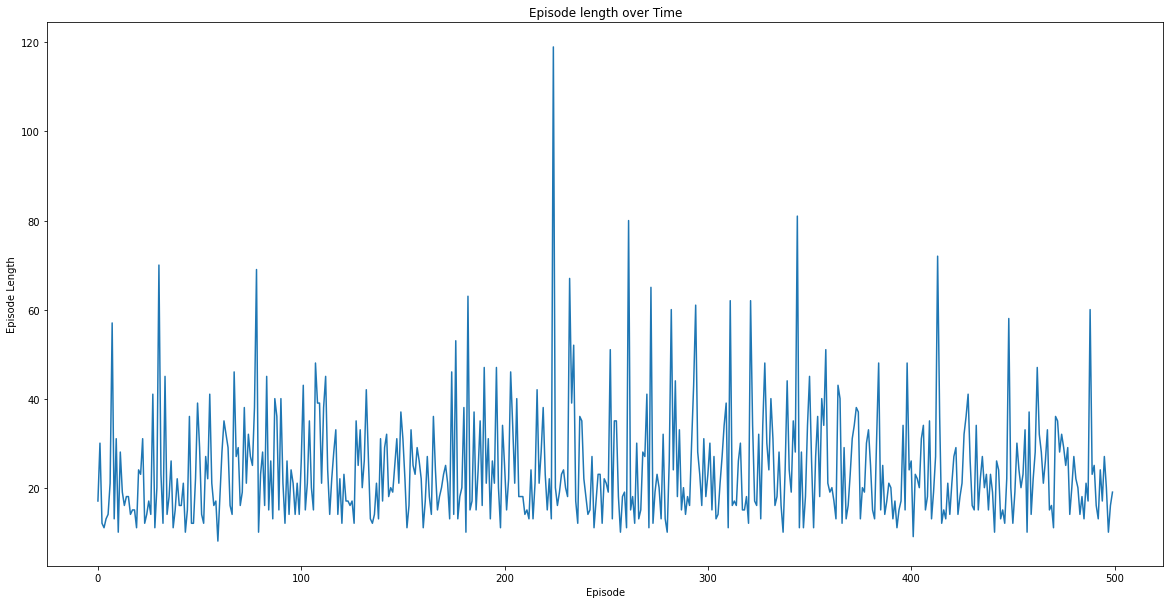

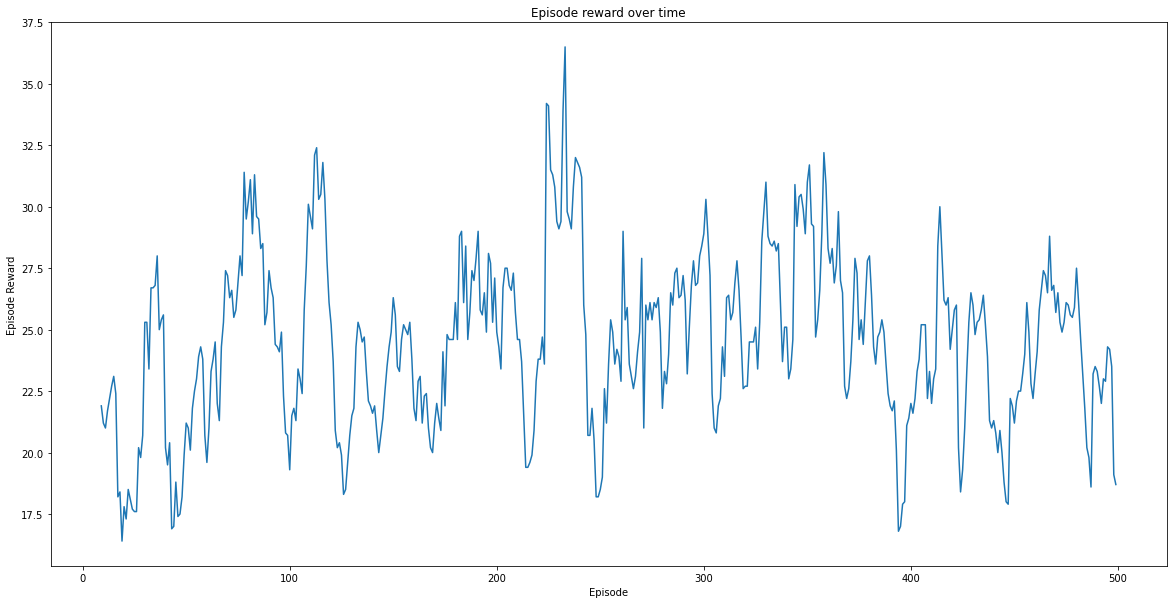

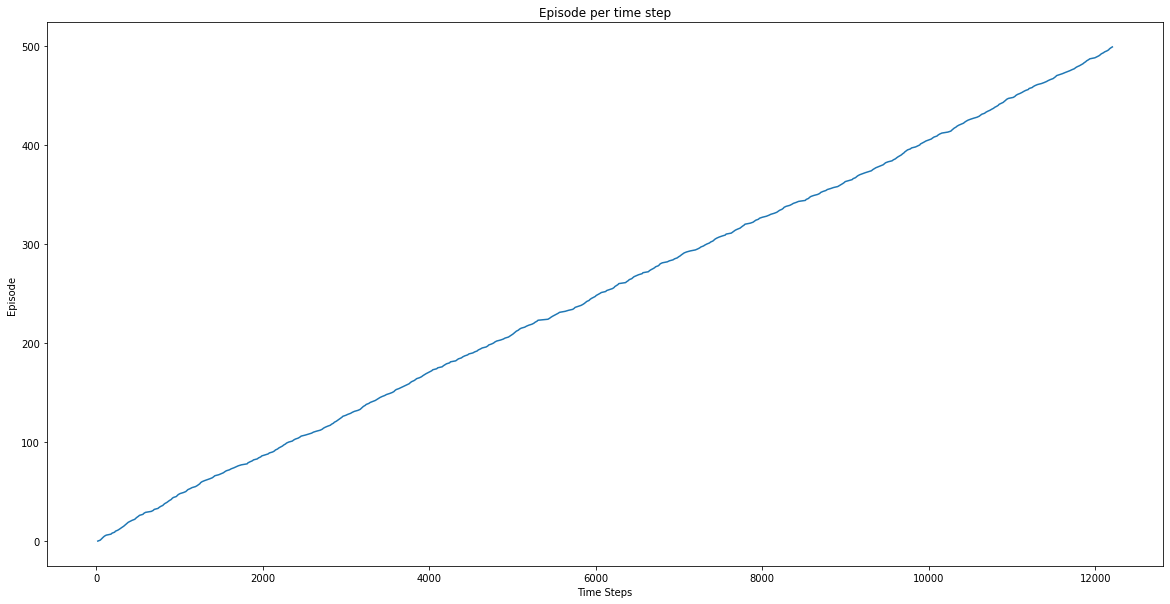

In [23]:
if __name__ == "__main__":
    env = gym.envs.make(ENVNAME)
    env = env.unwrapped
    env.seed(1)
    n_action = env.action_space.n
    n_feature = env.observation_space.shape[0]
    
    actor = Actor(n_features=n_feature, n_actions=n_action, lr=LEARNING_RATE_ACTOR)
    critic = Critic(n_features=n_feature, lr=LEARNING_RATE_CRITIC) 

    rec = update(actor, critic, env, num_episodes=NUM_EPISODES)
    #Plot the result
    Plot_the_result(rec)